In [1]:
import numpy as np
import csv
import random
import math
import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import copy
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torch.optim as optim
from torch import utils
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(1)
CUDA_LAUNCH_BLOCKING=1
#torch.autograd.set_detect_anomaly(True)
print (use_cuda)

torch.backends.cudnn.enabled
import os

import sigopt
import time
import pandas
import seaborn
import sklearn as sk

True


In [2]:
activation_functions = {
    'relu': nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'tanh': nn.Tanh(),
}

optimizers = {
    'gradient_descent': optim.SGD,
    'rmsprop': optim.RMSprop,
    'adam': optim.Adam,
}

def roll(tensor, shift, axis):

    if shift == 0:
        return tensor

    if axis < 0:
        axis += tensor.dim()

    dim_size = tensor.size(axis)
    after_start = dim_size - shift
    if shift < 0:
        after_start = -shift
        shift = dim_size - abs(shift)

    before = tensor.narrow(axis, 0, (dim_size - shift))
    after = tensor.narrow(axis, after_start, shift)
    return torch.cat([after, before], axis)

In [3]:
Dim = 10
J = np.zeros((Dim*Dim,Dim*Dim))
for i in range(Dim*Dim):
    for j in range(Dim*Dim):
        if ((i + 1 == j and j%Dim != 0) or (i - 1 == j and i%Dim != 0)):
            J[i,j] = 1
        if (i + Dim == j or i - Dim == j):
            J[i,j] = 1
        if ((i % Dim == 0 and j % Dim == Dim - 1) and (i + (Dim-1) == j)):
            J[i,j] = 1
        if ((j % Dim == 0 and i % Dim == Dim - 1) and (j + (Dim-1) == i)):
            J[i,j] = 1
        if ((i < Dim and j > Dim*Dim - 1 - Dim) and (i + (Dim*Dim - Dim) == j)):
            J[i,j] = 1
        if ((j < Dim and i > Dim*Dim - 1 - Dim) and (j + (Dim*Dim - Dim) == i)):
            J[i,j] = 1
J = torch.tensor(J).float().cuda()

In [4]:
def get_concentrations(lattices):
    lattices = lattices.view(lattices.shape[0],-1)
    mag = torch.sum(lattices,dim=1)
    return mag

In [5]:

###### Based off Wu et Al. Solving Statistical Mechanics Using Variational Autoregressive Networks


def KL_loss(DBG,lattices,epoch,temp,field,num_temps,num_fields):
    lattices = lattices.detach()
    probs = DBG.get_sample_prob(lattices,temp,field,epoch).view(lattices.shape[0])
    with torch.no_grad():
        energies = DBG.get_energies(lattices).view(lattices.shape[0])
        energies_norm = energies.view(-1)/temp.view(-1)
       
        F = (energies_norm + probs).view(-1,1)
        F_new = F - (field.view(-1,1) * lattices.view(-1,DBG.Nz).sum(dim=1).view(-1,1))/temp.view(-1,1)
        
        batch = int(lattices.shape[0]/(num_temps*num_fields))
        F_mean = F_new.view(-1,num_fields).view(num_temps,-1,num_fields)
        
        F_mean = F_mean.mean(dim=1).view(num_temps,1,num_fields).expand(num_temps,batch,num_fields)
        R = (F_new.view(-1) - F_mean.reshape(-1))/torch.abs(F_mean.reshape(-1))
        
    
    assert not R.requires_grad
    assert probs.requires_grad
    return torch.mean(R*probs)

In [6]:
def print_config(lattice,plt):
    
    lattice = (lattice + 1.)/2.
    Lat_Dim = int(np.sqrt(lattice.shape[0]))
    
    plt.imshow(np.reshape(lattice , (Lat_Dim,Lat_Dim)), cmap = 'Greys',vmin=0,vmax=1)
    
def print_set_config(lattice_list,name,limit = 3,row=2):
    if lattice_list.shape[0] < limit*row:
        num_images = lattice_list.shape[0]
    else:
        num_images = limit*row
    fig = plt.figure(figsize = (3,2))
    fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
    for image in range(num_images):
        ax = fig.add_subplot(row,num_images/row,image+1)
        ax.set_xticks([])
        ax.set_yticks([])
        img = lattice_list[image]
        print_config(img,plt)
    
    fig.savefig(name+'cond_test.pdf')
    plt.close(fig)
    

In [7]:
temps_sim = [1.5,2.0,2.5,3.0,3.5]
field_sim = [-0.4,-0.2,0,0.2,0.4]
coordinate_cutoff = 4.0
def train_model(model,optimizer,batch_size,epochs,temp_type,chem_type):
    
    epoch = 0
    temp = torch.zeros(len(temps_sim)*batch_size).cuda()
    field = torch.zeros(len(temps_sim)*batch_size).cuda()

    print_log_header()

    while epoch < epochs:
        if temp_type == 'Random Single':
            num_temps = 1
            t = 1.5 + 2*np.random.rand()
            for i in range(len(temps_sim)*batch_size):
                temp[i] = t
        elif temp_type == 'Random':
            t_fixed = []
            for i in range(5):
                t_temp = 1.5 + 2*np.random.rand()
                t_fixed.append(t_temp)
            num_temps = 5
            for i in range(len(temps_sim)*batch_size):
                temp[i] = t_fixed[int(i/batch_size)]
        else:
            num_temps = 5
            for i in range(len(temps_sim)*batch_size):
                temp[i] = temps_sim[int(i/batch_size)]
            
        if chem_type == 'Random Single':
            num_fields = 1
            f = -0.4 * 0.8*np.random.rand()
            for i in range(len(temps_sim)*batch_size):
                field[i] = f
        elif chem_type == 'Random':
            f_fixed = []
            for i in range(5):
                f_temp = -0.4 * 0.8*np.random.rand()
                f_fixed.append(f_temp)
            num_fields = 5
            for i in range(len(temps_sim)*batch_size):
                field[i] = f_fixed[int(i%(len(field_sim)))]
        else:
            num_fields = 5
            for i in range(len(temps_sim)*batch_size):
                field[i] = field_sim[int(i%(len(field_sim)))]
        
      
        epoch = epoch + 1

        lattices = model.forward(temp,field)
        
        
        kl_loss = KL_loss(model,lattices,epoch,temp,field,num_temps,num_fields)
        
        optimizer.zero_grad()
        kl_loss.backward()
        optimizer.step()
        
            
       
    return model

In [8]:
def print_log_header():
    print ('{:>8} {:>12}'\
       .format('epoch','train loss'))
    
def print_training_log(epoch, train_loss, test_loss=None):
    if test_loss is not None:
        print ('{:>8} {:>8} {:>12.4f} {:>12.4f}'\
                   .format(epoch, train_loss, test_loss))
        f.write('{:>8} {:>8} {:>12.4f} {:>12.4f}\n'\
                   .format(epoch, train_loss, test_loss))
    else:
        print ('{:>8} {:>8}'\
                   .format(epoch, train_loss))

In [9]:
def one_hot_to_sites(lattices,Nz):
    lattices = lattices.view(-1,Nz,2)
    lattices = torch.argmax(lattices,dim=2)
    lattices = 2*lattices - 1.0
    lattices = lattices.view(-1,Nz)
    return lattices.float()
    
def sites_to_one_hot(lattices):
    lattices = lattices.view(lattices.shape[0],-1)
    lattices = (0.5*(lattices + 1)).long()
    one_hot_lattices = torch.zeros(lattices.shape[0],lattices.shape[1],2).float().cuda()
    one_hot_lattices = one_hot_lattices.scatter_(2,lattices.view(lattices.shape[0],-1,1),1.0)
    return one_hot_lattices.detach()

In [10]:
def mask_weight(m,disp):
    num_sites = m.shape[1]
    num_components = 2
    mask = torch.zeros(m.shape)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if (disp == 0):
                if (j == 0 or j == 1 ):
                    mask[i,j] = 1.0
                elif ((j-2) < num_components*int(i/num_components) ):
                    mask[i,j] = 1.0
            if (disp == 1):
                if (j == 0 or j==1 ):
                    mask[i,j] = 1.0
                if ((j-2) < num_components*int(i/num_components) + num_components):
                    mask[i,j] = 1.0
    mask = mask.detach()
    m_masked = m*mask
    return m_masked

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [11]:
class autoreg_model(nn.Module):
    def __init__(self,Nz,assignments):
        super().__init__()
        self.Nz = Nz
        self.Dim = int(math.sqrt(Nz))
        self.assignments = assignments
        self.activation = activation_functions[assignments['activation']]
        self.lsoftmax = torch.nn.LogSoftmax(dim=2)
        self.softmax = torch.nn.Softmax(dim=2)
        self.num_layers = int(assignments['Layers'])
        
        self.shared_layer = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer.weight,0))
        self.mask_1 = mask_weight(torch.ones_like(self.shared_layer.weight),0).cuda()
        
        self.shared_layer.weight.register_hook(get_zero_grad_hook(self.mask_1))
        
        
        self.shared_layer_2 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_2.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_2.weight,1))
        self.mask_2 = mask_weight(torch.ones_like(self.shared_layer_2.weight),1).cuda()
        self.shared_layer_2.weight.register_hook(get_zero_grad_hook(self.mask_2))
        
        self.shared_layer_3 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_3.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_3.weight,1))
        self.mask_3 = mask_weight(torch.ones_like(self.shared_layer_3.weight),1).cuda()
        self.shared_layer_3.weight.register_hook(get_zero_grad_hook(self.mask_3))
        
        self.shared_layer_4 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_4.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_4.weight,1))
        self.mask_4 = mask_weight(torch.ones_like(self.shared_layer_4.weight),1).cuda()
        self.shared_layer_4.weight.register_hook(get_zero_grad_hook(self.mask_4))
        
    def get_sample_prob(self,lattices,temp,field,epoch):
        #print(self.shared_layer.weight)
        
        batch_size = temp.shape[0]
        samples = sites_to_one_hot(lattices).view(batch_size,-1)
        net_in = torch.cat((field.view(-1,1),samples),dim=1)
        net_in = torch.cat((temp.view(-1,1),net_in),dim=1)
        conditional = self.activation(self.shared_layer(net_in))
        conditional = torch.cat((field.view(-1,1),conditional),dim=1)
        conditional = torch.cat((temp.view(-1,1),conditional),dim=1)
        conditional = self.shared_layer_2(conditional)
        if self.num_layers > 2:
            conditional = self.activation(conditional)
            conditional = torch.cat((field.view(-1,1),conditional),dim=1)
            conditional = torch.cat((temp.view(-1,1),conditional),dim=1)
            conditional = self.shared_layer_3(conditional)
            
        if self.num_layers > 3:
            conditional = self.activation(conditional)
            conditional = torch.cat((field.view(-1,1),conditional),dim=1)
            conditional = torch.cat((temp.view(-1,1),conditional),dim=1)
            conditional = self.shared_layer_4(conditional)
        
        
        
        
        conditional = conditional.view(-1,self.Nz,2)
        Probs = self.lsoftmax(conditional)
        samples = samples.detach()
        assert Probs.requires_grad == True
        site_prob = Probs*(samples.view(-1,self.Nz,2))
        probs = torch.sum(torch.sum(site_prob,dim=2),dim=1)
        return probs
        
    def forward(self,temp,field):
        
        batch_size = temp.shape[0]
        temp = temp.view(-1,1)
        field = field.view(-1,1)
        lattices = torch.zeros(batch_size,2*self.Nz).cuda()
        for site in range(self.Nz):
            net_in = torch.cat((field,lattices),dim=1)
            net_in = torch.cat((temp,net_in),dim=1)
            conditional = self.activation(self.shared_layer(net_in))
            conditional = torch.cat((field,conditional),dim=1)
            conditional = torch.cat((temp,conditional),dim=1)
            conditional = self.shared_layer_2(conditional)
            if self.num_layers > 2:
                conditional = self.activation(conditional)
                conditional = torch.cat((field.view(-1,1),conditional),dim=1)
                conditional = torch.cat((temp.view(-1,1),conditional),dim=1)
                conditional = self.shared_layer_3(conditional)
            
            if self.num_layers > 3:
                conditional = self.activation(conditional)
                conditional = torch.cat((field.view(-1,1),conditional),dim=1)
                conditional = torch.cat((temp.view(-1,1),conditional),dim=1)
                conditional = self.shared_layer_4(conditional)
            
            conditional = conditional.view(-1,self.Nz,2)
            Probs = self.softmax(conditional)
            To_Sample = Probs[:,site,:]
            sample = torch.multinomial(To_Sample,1).view(-1,1)
            lattices = lattices.view(-1,self.Nz,2)
            lattices[:,site,:] = lattices[:,site,:].scatter_(1,sample,1)
            lattices = lattices.view(-1,2*self.Nz)
        #print(lattices.requires_grad)
        lattices = one_hot_to_sites(lattices,self.Nz)
        return lattices

def create_model(Nz,assignments):
    class Discrete_Boltzmann_Generator(nn.Module):
        def __init__(self,Nz,assignments):
            super().__init__()
            self.Nz = Nz
            self.Dim = int(math.sqrt(Nz))
            self.assignment = assignments
            self.Model = autoreg_model(Nz,assignments)
            
        def forward(self,temp,field):
            return self.Model.forward(temp,field)
            
        def get_energies(self,lattices):
            energies = -0.5 * torch.matmul(lattices.view(-1,1,self.Dim*self.Dim) , torch.matmul(J,lattices.view(-1,self.Dim*self.Dim,1)))
            return energies
        
        def get_sample_prob(self,sample,temp,field,epoch):
            return self.Model.get_sample_prob(sample,temp,field,epoch)
        
    model = Discrete_Boltzmann_Generator(Nz,assignments).cuda()
    batch_size = int(assignments['batch_size'])
    optimizer = optimizers[assignments['optimizer']](model.parameters(), lr=10**assignments['log_learning_rate'])
    epochs = assignments['epochs']
    temp_type = assignments['temp_type']
    chem_type = assignments['Chem_type']
    model = train_model(model,optimizer,batch_size,epochs,temp_type,chem_type)
    
    return model

In [12]:
Dim = 10

NameError: name 'model' is not defined

In [13]:
def get_Ness(model,lattices,tmp,temp_b,field_b):
    size = lattices.shape[0]
    iters = int(size/1000)
    lattices = lattices.view(-1,iters,100)
    for i in range(iters):
        energies = (model.get_energies(lattices[:,i,:])/(tmp)).view(-1)
        prob = model.get_sample_prob(lattices[:,i,:],temp_b,field_b,1000).view(-1)
        temp_pot = -(field_b.view(-1)*lattices[:,i,:].sum(dim=1).view(-1))/(tmp)
        temp_pot = energies+prob+temp_pot
        if i ==0:
            pot = temp_pot
        else:
            pot = torch.cat((pot,temp_pot),dim=0)
    log_rw = -pot
    log_rw = log_rw - log_rw.mean()
    rw = torch.exp(log_rw)
    
    Ness = torch.sum(rw)**2 / torch.sum(rw**2)
    return Ness

In [2]:
from sigopt import Connection

#conn = Connection(client_token="RAFA GB TOKEN HERE")
#id_n = 356514
#assignments = conn.experiments(id_n).best_assignments().fetch().data[0].assignments

In [14]:
assignments = {
  "Chem_type": "Fixed",
  "Layers": "3",
  "activation": "tanh",
  "batch_size": "250",
  "epochs": 22761.888655897787,
  "log_learning_rate": -2.9228066668436794,
  "optimizer": "rmsprop",
  "temp_type": "Random"
}

In [15]:
model = create_model(100,assignments)

   epoch   train loss


In [ ]:
print(model)
print(assignments)

In [71]:
def get_susceptiblity(field,temp,size):
    field = torch.tensor(field).cuda()
    field.requires_grad_()
    temps = torch.zeros(size).cuda()
    fields = torch.ones(size).cuda()*field
    for i in range(size):
        temps[i] = temp
    lattices = model.forward(temps,fields)
    
    probs = model.get_sample_prob(lattices,temps,fields,1000)
    concs = lattices.sum(dim=1)
    
    torch.mean(probs*concs).backward(retain_graph=True)
    
    d_u = field.grad

    return d_u

In [72]:
def get_sus_fluc(field,temp,size):
    field = torch.tensor(field).cuda()
    field.requires_grad_()
    temps = torch.zeros(size).cuda()
    fields = torch.ones(size).cuda()*field
    for i in range(size):
        temps[i] = temp
    lattices = model.forward(temps,fields)
    
    probs = model.get_sample_prob(lattices,temps,fields,1000)
    concs = lattices.sum(dim=1)
    
    term_one = torch.mean(concs**2)
    term_two = torch.mean(concs)**2
    fluct = term_one-term_two
    x = fluct / temp
    return x

In [73]:
def map_susceptiblity():
    b = np.linspace(-0.4,0.4,81)
    t = np.linspace(1.5,3.5,24)
    
    b_plot = []
    t_plot = []
    d_plot = []
    x_plot = []
    for b_it in b:
        for t_it in t:
            b_plot.append(b_it)
            t_plot.append(t_it)
            d_it = get_susceptiblity(b_it,t_it,10000).cpu().numpy()
            x_it = get_sus_fluc(b_it,t_it,10000).cpu().detach().numpy()

            d_plot.append(d_it)
            x_plot.append(x_it)
        print(b_it)

    b_plot = np.asarray(b_plot).reshape(-1)
    t_plot = np.asarray(t_plot).reshape(-1)
    d_plot = np.asarray(d_plot).reshape(-1)
    x_plot = np.asarray(x_plot).reshape(-1)
    print(b_plot.shape)
    print(t_plot.shape)
    print(d_plot.shape)
    vma = max(np.max(d_plot),np.max(x_plot))
    vmi = min(np.min(d_plot),np.min(x_plot))
    plt.hist2d(b_plot,t_plot, bins = (81,24), weights = d_plot,cmap='inferno')
    plt.colorbar()
    plt.show()
    plt.hist2d(b_plot,t_plot, bins = (81,24), weights = x_plot,cmap='inferno')
    plt.colorbar()
    plt.show()
    return d_plot,x_plot

-0.4
-0.39
-0.38
-0.37
-0.36000000000000004
-0.35000000000000003
-0.34
-0.33
-0.32
-0.31000000000000005
-0.30000000000000004
-0.29000000000000004
-0.28
-0.27
-0.26
-0.25
-0.24000000000000002
-0.23
-0.22000000000000003
-0.21000000000000002
-0.2
-0.19000000000000003
-0.18000000000000002
-0.17
-0.16000000000000003
-0.15000000000000002
-0.14
-0.13
-0.12
-0.11000000000000004
-0.10000000000000003
-0.09000000000000002
-0.08000000000000002
-0.07
-0.06
-0.04999999999999999
-0.040000000000000036
-0.030000000000000027
-0.020000000000000018
-0.010000000000000009
0.0
0.010000000000000009
0.019999999999999962
0.02999999999999997
0.03999999999999998
0.04999999999999999
0.06
0.07
0.07999999999999996
0.08999999999999997
0.09999999999999998
0.10999999999999999
0.12
0.13
0.14
0.15000000000000002
0.16000000000000003
0.17000000000000004
0.17999999999999994
0.18999999999999995
0.19999999999999996
0.20999999999999996
0.21999999999999997
0.22999999999999998
0.24
0.25
0.26
0.27
0.28
0.29000000000000004
0.30000

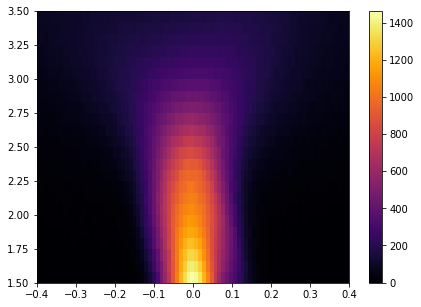

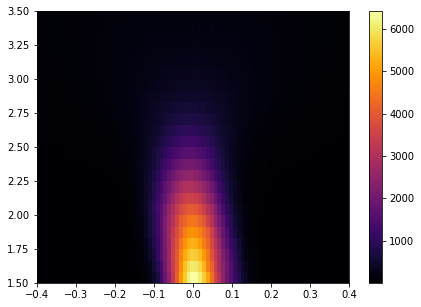

In [74]:
d_plot_mag,x_plot_mag = map_susceptiblity()

In [75]:
def get_heat_cap(field,temp,size):
    temp = torch.tensor(temp).cuda()
    temp.requires_grad_()
    temps = torch.ones(size).cuda()*temp
    fields = torch.zeros(size).cuda()
    for i in range(size):
        fields[i] = field
    lattices = model.forward(temps,fields)
    
    
    probs = model.get_sample_prob(lattices,temps,fields,1000)
    energies_old = model.get_energies(lattices).view(-1)
    
    torch.mean(probs*energies_old).backward(retain_graph=True)
    
    d_t = temp.grad

    return d_t

def get_hc_fluc(field,temp,size):
    field = torch.tensor(field).cuda()
    field.requires_grad_()
    temps = torch.zeros(size).cuda()
    fields = torch.ones(size).cuda()*field
    for i in range(size):
        temps[i] = temp
    lattices = model.forward(temps,fields)
    energies_old = model.get_energies(lattices).view(-1)
    
    term_one = torch.mean(energies_old**2)
    term_two = torch.mean(energies_old)**2
    fluct = term_one-term_two
    x = fluct / temp
    #print(d_u)
    return x

In [76]:
def map_heat_cap():
    b = np.linspace(-0.4,0.4,81)
    t = np.linspace(1.5,3.5,24)
    
    b_plot = []
    t_plot = []
    d_plot = []
    x_plot = []
    for b_it in b:
        #print(b_it)
        for t_it in t:
            b_plot.append(b_it)
            t_plot.append(t_it)
            d_it = get_heat_cap(b_it,t_it,10000).cpu().numpy()
            x_it = get_hc_fluc(b_it,t_it,10000).cpu().detach().numpy()
            d_plot.append(d_it)
            x_plot.append(x_it)
            #print(d_it/x_it)
    #print(b_it)
    b_plot = np.asarray(b_plot).reshape(-1)
    t_plot = np.asarray(t_plot).reshape(-1)
    d_plot = np.asarray(d_plot).reshape(-1)
    x_plot = np.asarray(x_plot).reshape(-1)
    print(b_plot.shape)
    print(t_plot.shape)
    print(d_plot.shape)
    vma = max(np.max(d_plot),np.max(x_plot))
    vmi = min(np.min(d_plot),np.min(x_plot))
    plt.hist2d(b_plot,t_plot, bins = (81,24), weights = d_plot,cmap='inferno')
    plt.colorbar()
    plt.show()
    plt.hist2d(b_plot,t_plot, bins = (81,24), weights = x_plot,cmap='inferno')
    plt.colorbar()
    plt.show()
    return d_plot,x_plot

(1944,)
(1944,)
(1944,)


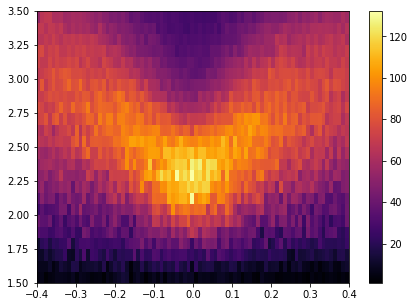

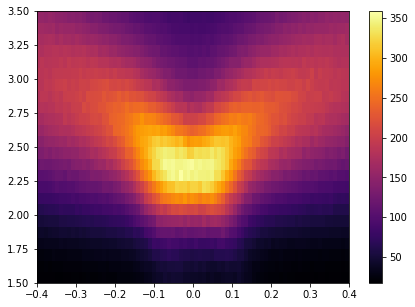

In [77]:
d_plot_hc,x_plot_hc = map_heat_cap()

In [78]:
b = np.linspace(-0.4,0.4,81)
t = np.linspace(1.5,3.5,24)
b_plot = []
t_plot = []
for b_it in b:
        #print(b_it)
        for t_it in t:
            b_plot.append(b_it)
            t_plot.append(t_it)
b_plot = np.asarray(b_plot).reshape(-1)
t_plot = np.asarray(t_plot).reshape(-1)

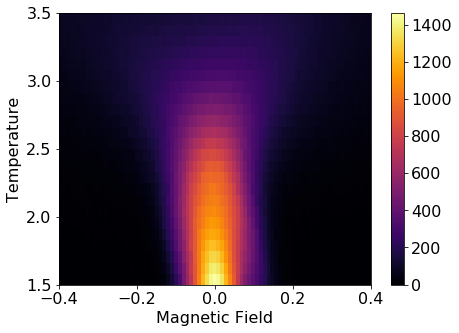

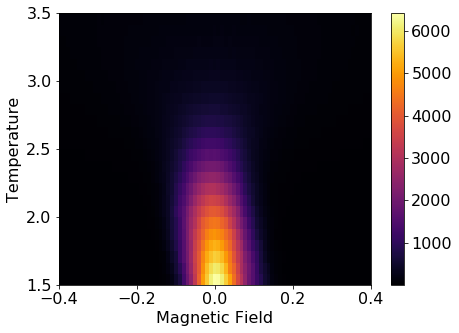

In [93]:

hfont = {'fontname':'Arial'}
plt.hist2d(b_plot,t_plot, bins = (81,24), weights = d_plot_mag,cmap='inferno')
plt.rcParams["figure.figsize"] = (7,5)
plt.xlabel('Magnetic Field',fontsize=16,**hfont)
plt.ylabel('Temperature',fontsize=16,**hfont)
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.yticks([1.5,2.0,2.5,3.0,3.5])
plt.xticks([-0.4,-0.2,0.0,0.2,0.4])
cb = plt.colorbar()
imaxes = plt.gca()
plt.axes(cb.ax)
plt.yticks(fontsize=16,fontname = "Arial")
plt.savefig("Sus_Deriv_Final_Submission.pdf",bbox_inches='tight')
plt.show()


plt.hist2d(b_plot,t_plot, bins = (81,24), weights = x_plot_mag,cmap='inferno')
plt.rcParams["figure.figsize"] = (7,5)
plt.xlabel('Magnetic Field',fontsize=16,**hfont)
plt.ylabel('Temperature',fontsize=16,**hfont)
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.yticks([1.5,2.0,2.5,3.0,3.5])
plt.xticks([-0.4,-0.2,0.0,0.2,0.4])
cb = plt.colorbar()
imaxes = plt.gca()
plt.axes(cb.ax)
plt.yticks(fontsize=16,fontname = "Arial")
#cb.set_ticks([0.0,0.25,0.5,0.75,1.0])
plt.savefig("Sus_Standard_Final_Submission.pdf",bbox_inches='tight')
plt.show()

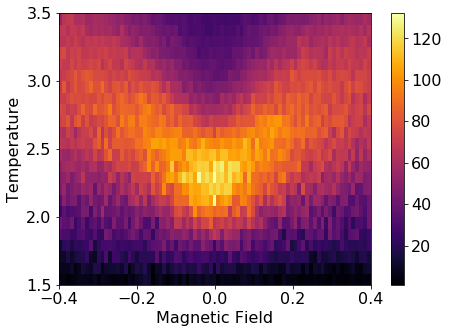

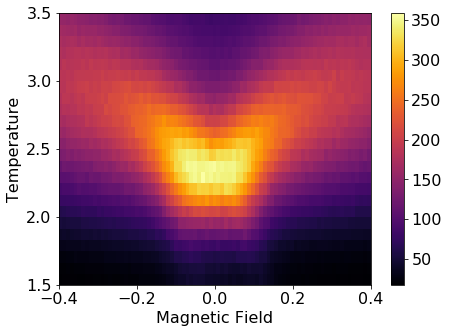

In [94]:
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
temps = np.linspace(1.5,3.5,24)
plt.hist2d(b_plot,t_plot, bins = (81,24), weights = d_plot_hc,cmap='inferno')

plt.rcParams["figure.figsize"] = (7,5)
plt.xlabel('Magnetic Field',fontsize=16,**hfont)
plt.ylabel('Temperature',fontsize=16,**hfont)
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.yticks([1.5,2.0,2.5,3.0,3.5])
plt.xticks([-0.4,-0.2,0.0,0.2,0.4])
cb = plt.colorbar()
imaxes = plt.gca()
plt.axes(cb.ax)
plt.yticks(fontsize=16,fontname = "Arial")
#cb.set_ticks([0.0,0.25,0.5,0.75,1.0])
plt.savefig("HC_Deriv_Final_Submission.pdf",bbox_inches='tight')

plt.show()





plt.hist2d(b_plot,t_plot, bins = (81,24), weights = x_plot_hc,cmap='inferno')

plt.rcParams["figure.figsize"] = (7,5)
plt.xlabel('Magnetic Field',fontsize=16,**hfont)
plt.ylabel('Temperature',fontsize=16,**hfont)
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.yticks([1.5,2.0,2.5,3.0,3.5])
plt.xticks([-0.4,-0.2,0.0,0.2,0.4])
cb = plt.colorbar()
imaxes = plt.gca()
plt.axes(cb.ax)
plt.yticks(fontsize=16,fontname = "Arial")
#cb.set_ticks([0.0,0.25,0.5,0.75,1.0])
plt.savefig("HC_Standard_Final_Submission.pdf",bbox_inches='tight')

plt.show()

In [81]:
def examine_phase(model,lattices,tmp,temp_b,field_b,mag):
    #print(lattices)
    prob = model.get_sample_prob(lattices,temp_b,field_b,1000).view(-1)
    with torch.no_grad():
        
        energies = (model.get_energies(lattices)/(tmp)).view(-1)
        
        
        pot = -(field_b.view(-1)*lattices.sum(dim=1).view(-1))/(tmp)
        pot = energies+prob+pot
        log_rw = -pot
        stored = log_rw.mean()
        log_rw_corr = log_rw - stored
        rw = torch.exp(log_rw_corr)
        rw_norm = rw/(rw.sum())
        est_part = torch.exp(log_rw_corr).mean()
        log_z = torch.log(est_part)+stored
        
        conc_mean = (mag.view(-1)*rw_norm.view(-1)).sum().cpu().detach().numpy().item()

        gp = -tmp*log_z
        
    return conc_mean,gp

In [82]:

temps = np.linspace(1.5,3.5,101)
field_sim = [-0.4,-0.2,0,0.2,0.4]

fields_test = np.linspace(0.0,0.4,9)

fe_out_stored = np.zeros((9,101))
fe_out_std_stored = np.zeros((9,101))

fe = np.zeros((9,101,50))

for k in range(fields_test.shape[0]):
    fs = fields_test[k]
    fe_comp = np.zeros((101,50))
    count = 0
    for tmp in temps:
        temp = torch.zeros(20000).cuda()
        for i in range(temp.shape[0]):
            temp[i] = tmp
        
        field = torch.zeros(20000).cuda()
        for i in range(temp.shape[0]):
            field[i] = fs

        out = np.zeros((50))
        for i in range(50):
            lattices = model.forward(temp,field)
            mag = lattices.sum(dim=1)
            conc_mean,pot = examine_phase(model,lattices,tmp,temp,field,mag)
            fe_comp[count,i] = pot/100

        count = count + 1

    out = fe_comp.mean(axis = 1)
    outstd = fe_comp.std(axis = 1)
    
    fe_out_stored[k,:] = out
    fe_out_std_stored[k,:] = outstd
    
    fe[k,:,:] = fe_comp


In [83]:
np.savetxt("fe_stored_final_20000.csv", fe_out_stored, delimiter=",")
np.savetxt("fe_std_final_20000.csv",  fe_out_std_stored, delimiter=",")
#np.savetxt("fe.csv",fe,delimiter=",")
np.save("fe_final_20000", fe)

In [84]:
temps = np.linspace(1.5,3.5,5)

fields_test = np.linspace(0.0,0.0,50)

fe_out_stored_zero = np.zeros((50,5))

for k in range(fields_test.shape[0]):
    fs = fields_test[k]
    
    count = 0
    for tmp in temps:
        temp = torch.zeros(20000).cuda()
        for i in range(temp.shape[0]):
            temp[i] = tmp
        field = torch.zeros(20000).cuda()
        for i in range(temp.shape[0]):
            field[i] = fs

        
        lattices = model.forward(temp,field)
        mag = lattices.sum(dim=1)
        conc_mean,pot = examine_phase(model,lattices,tmp,temp,field,mag)
        fe_out_stored_zero[k,count] = pot/100

        count = count + 1


In [85]:
np.savetxt("fe_stored_zero_new_20000.csv",fe_out_stored_zero, delimiter=",")

In [86]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#003f5c
#58508d
#bc5090
#ff6361
#ffa600
N = 5
newcolors = []
newcolors.append((0,63,92))
newcolors.append((88,80,141)) 
newcolors.append((188,80,144)) 
newcolors.append((255,99,97)) 
newcolors.append((255,166,0)) 

newcolors_norm = []
for i in newcolors:
    curr = np.asarray(i)
    print(curr)
    curr = curr/255.0
    curr = tuple(curr)
    newcolors_norm.append(curr)

cmap_name = 'my_list'
newcmp = LinearSegmentedColormap.from_list(cmap_name,newcolors_norm)

[ 0 63 92]
[ 88  80 141]
[188  80 144]
[255  99  97]
[255 166   0]


In [143]:
temp = torch.zeros(9).cuda()
for i in range(temp.shape[0]):
    temp[i] = 1.5
tmp = temp[0]
field = torch.zeros(9).cuda()
for i in range(temp.shape[0]):
    field[i] = -0.4

lattices = model.forward(temp,field)
#print(lattices)
print_set_config(lattices.cpu().detach().numpy(),"1.5_-0.4_final_")

In [125]:
def test_symmetry_one(num_samples):
    bounds_t = [1.5,3.5]
    bounds_f = [-0.4,0.4]
    temp = torch.zeros(1000).cuda()
    field = torch.zeros(1000).cuda()
    for i in range(temp.shape[0]):
        temp[i] = bounds_t[0] + (bounds_t[1]-bounds_t[0])*np.random.rand()
        field[i] = bounds_f[0] + (bounds_f[1]-bounds_f[1])*np.random.rand()
        if i > 900:
            field[i] = 0.0
    
    lattices = model.forward(temp,field)
    
    lattices_g = copy.deepcopy(lattices)
    lattices_g = lattices_g.view(-1,Dim,Dim)
    
    for i in range(1000):
        lattices_g[i] = roll(lattices_g[i,:,:].view(1,Dim,Dim),np.random.randint(Dim),1)

        lattices_g[i] = roll(lattices_g[i,:,:].view(1,Dim,Dim),np.random.randint(Dim),2)

        lattices_g[i] = torch.rot90(lattices_g[i,:,:].view(1,Dim,Dim),np.random.randint(4),[1,2])
        
        if field[i] == 0.0:
            if np.random.rand() > 0.5:
                lattices_g[i] = lattices_g[i] * -1.0
        
    lattices_g = lattices_g.reshape(-1,Dim*Dim)
    
    lat_init = lattices[150,:]
    lat_g = lattices_g[150,:]
    
    plt.imshow(np.reshape((lat_init.cpu().detach().numpy() + 1.)/2. , (10,10)), cmap = 'Greys',vmin=0,vmax=1)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.savefig('Lat_init_Final_Submission.pdf',bbox_inches='tight')
    plt.show()
    plt.imshow(np.reshape((lat_g.cpu().detach().numpy() + 1.)/2. , (10,10)), cmap = 'Greys',vmin=0,vmax=1)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.savefig('Lat_g_no_Final_Submission.pdf',bbox_inches='tight')
    plt.show()
    log_prob_init = model.get_sample_prob(lattices,temp,field,1000)
    
    
    log_prob_g = model.get_sample_prob(lattices_g,temp,field,1000)
    
    correlation_matrix = np.corrcoef(log_prob_init.cpu().detach().numpy(), log_prob_g.cpu().detach().numpy())
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2

    print(r_squared)
    plt.rcParams["figure.figsize"] = (5,5)
    plt.scatter(log_prob_init.cpu().detach().numpy(),log_prob_g.cpu().detach().numpy(),color=newcmp(0.0),alpha=0.16)
    c_temp = 0.0*np.ones((log_prob_init.cpu().detach().numpy()[150].shape))
    col = plt.cm.hsv([0.0])  
    print(col)
    print(c_temp)
    print(log_prob_init.cpu().detach().numpy()[150])
    plt.scatter(log_prob_init.cpu().detach().numpy()[150],log_prob_g.cpu().detach().numpy()[150],color=newcmp(0.75))
    plt.gca().set(xlim=(-75, 5), ylim=(-75, 5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Log Prob x',fontsize=16,**hfont)
    plt.ylabel('Log Prob G(x)',fontsize=16,**hfont)
    plt.xticks(fontsize = 16,fontname = "Arial") 
    plt.yticks(fontsize = 16,fontname = "Arial")
    plt.yticks([0,-20,-40,-60])
    plt.xticks([0,-20,-40,-60])
    
    space = np.linspace(-75,5)
    plt.plot(space,space,color=newcmp(0.75),linestyle = '--')
    plt.text(-70, -10, 'R$^{2}$ = '+str(round(r_squared, 4)),  fontsize = 24,fontname = "Arial",va='center', rotation='horizontal')
    
    plt.savefig('Symmetries_Final_Submission.pdf',bbox_inches='tight')
    
    plt.show()
    

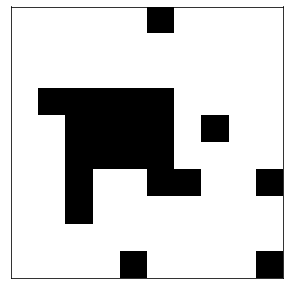

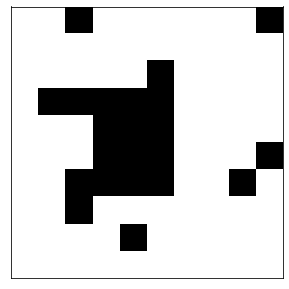

0.999388553019731
[[1. 0. 0. 1.]]
0.0
-42.791565


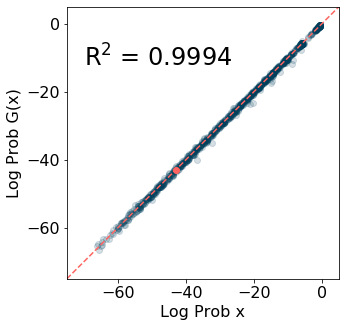

In [126]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
test_symmetry_one(2500)

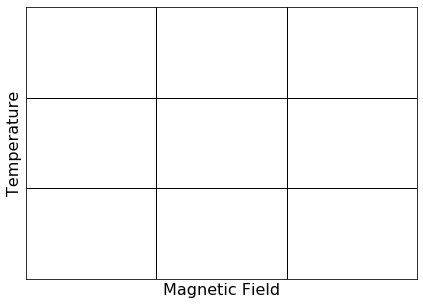

In [56]:
plt.rcParams["figure.figsize"] = (7,5)
plt.xlabel('Magnetic Field',fontsize=16,**hfont)
plt.ylabel('Temperature',fontsize=16,**hfont)
plt.yticks([])
plt.xticks([])
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.vlines(0.333333,0.0,1.0,color='black',linewidth=1.0)
plt.vlines(0.66666666,0.0,1.0,color='black',linewidth=1.0)
plt.hlines(0.333333,0.0,1.0,color='black',linewidth=1.0)
plt.hlines(0.66666666,0.0,1.0,color='black',linewidth=1.0)
plt.savefig('Frame.pdf',bbox_inches='tight')
plt.show()

In [87]:
def get_Ness(model,lattices,tmp,temp_b,field_b):
    size = lattices.shape[0]
    iters = int(size/1000)
    lattices = lattices.view(-1,iters,100)
    for i in range(iters):
        energies = (model.get_energies(lattices[:,i,:])/(tmp)).view(-1)
        prob = model.get_sample_prob(lattices[:,i,:],temp_b,field_b,1000).view(-1)
        temp_pot = -(field_b.view(-1)*lattices[:,i,:].sum(dim=1).view(-1))/(tmp)
        temp_pot = energies+prob+temp_pot
        if i ==0:
            pot = temp_pot
        else:
            pot = torch.cat((pot,temp_pot),dim=0)
    log_rw = -pot
    log_rw = log_rw - log_rw.mean()
    rw = torch.exp(log_rw)
    
    Ness = torch.sum(rw)**2 / torch.sum(rw**2)
    return Ness

In [88]:
chem_p = np.linspace(-0.4,0.4,80)
temps = np.linspace(1.5,3.5,24)
num = 10000
temps_f = torch.zeros(1000).cuda()
ch_p_f = torch.zeros(1000).cuda()
Ness = np.zeros((temps.shape[0],chem_p.shape[0]))
for i in range(temps.shape[0]):
    for j in range(chem_p.shape[0]):
        for m in range(10):
            for k in range(1000):
                temps_f[k] = temps[i]
                ch_p_f[k] = chem_p[j]
            temp_lattices = model.forward(temps_f,ch_p_f)
            if m ==0:
                lattices = temp_lattices
            else:
                lattices = torch.cat((lattices,temp_lattices),dim=0)
        N_temp = get_Ness(model,lattices,temps[i],temps_f,ch_p_f)
        Ness[i,j] = N_temp/num
        print("done")

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [89]:
all_temps = []
all_chem_p = []
for i in range(temps.shape[0]):
    for j in range(80):
        all_temps.append(temps[i])
        all_chem_p.append(chem_p[j])

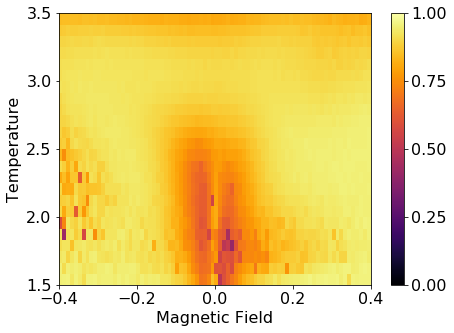

In [95]:
import matplotlib as mpl
mpl.rc('font',family='Arial')


hfont = {'fontname':'Arial'}
temps = np.linspace(1.5,3.5,24)
plt.hist2d(all_chem_p,all_temps,bins = (80,24), weights = Ness.reshape(-1),cmap="inferno",vmin=0.0,vmax=1.0)
plt.rcParams["figure.figsize"] = (7,5)
plt.xlabel('Magnetic Field',fontsize=16,**hfont)
plt.ylabel('Temperature',fontsize=16,**hfont)
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.yticks([1.5,2.0,2.5,3.0,3.5])
plt.xticks([-0.4,-0.2,0.0,0.2,0.4])
cb = plt.colorbar()
imaxes = plt.gca()
plt.axes(cb.ax)
plt.yticks(fontsize=16,fontname = "Arial")
cb.set_ticks([0.0,0.25,0.5,0.75,1.0])
plt.savefig("NESS_Final_Submission.pdf",bbox_inches='tight')



In [96]:
flat_Ness = Ness.reshape(-1)

count = 0
for i in range(flat_Ness.shape[0]):
    if flat_Ness[i] <0.3:
        count+=1
    
print(count/flat_Ness.shape[0])

0.0


0.4028235971927643


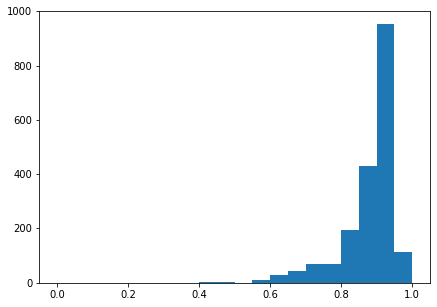

In [97]:
plt.hist(Ness.reshape(-1),bins = 20,range = [0,1])
print(np.min(Ness))

In [98]:
torch.save(model.state_dict(), "Ising_Final_Submission")

In [144]:
np.save("Ising_NESS_data_final_submission", Ness)